# DiploDatos 2022 - Mentoría "Churn Prediction: ¿Cómo retengo a mis clientes? Machine Learning aplicado a un caso de negocio"

Grupo 1:
- Marquez, Micael 
- Mantovani, María Laura
- Ruales, Fanny
- Ruiz, Rodrigo Hernán

#Importación de librerías

In [ ]:
#Analisis y visualizacion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Otras
import datetime
#Modelos
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report

#Lectura de archivo de datos desde Google Drive

In [ ]:
# Al ejecutar el código, se mostrará una ventana solicitando permisos de acceso a Drive con la cuenta de correo (personal)
# se deben aceptar los permisos para poder acceder al archivo compartido que contiene el dataset a trabajar

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def connect_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_csv(filename)

drive = connect_to_drive()
salida_tp2 = read_csv_from_drive(drive, '1LBYYXqXlPhphrXPGtls0z3Aps93QLSdT' , 'salida_TP2.csv')
# salida_tp2 = read_csv_from_drive(drive, '1bbCiNmO34mnhFhA0E_QOiFTdL7-0NDZg' , 'salida_TP25_pca.csv')

In [ ]:
#Copia del DF original
df = salida_tp2.copy()
df.head(3)

,userId,sessionId,hour,day_week,day,month,last_level,time_reg_to_last,n_artists,n_songs,...,average_days_bt_session,distinct_count_of_days,if_error,error_count,if_help,help_count,churn_cancellation,pca1,pca2,pca3
0,0.0,0.0,0.173913,0.0,0.233333,0.0,1.0,0.195229,0.177632,0.122176,...,0.096735,0.163636,0.0,0.0,0.0,0.0,0.0,-0.722317,0.115193,-0.259434
1,0.0,0.0,0.173913,0.0,0.233333,0.0,1.0,0.195229,0.177632,0.122176,...,0.096735,0.163636,0.0,0.0,0.0,0.0,0.0,-0.722317,0.115193,-0.259434
2,0.0,0.0,0.173913,0.0,0.233333,0.0,1.0,0.195229,0.177632,0.122176,...,0.096735,0.163636,0.0,0.0,0.0,0.0,0.0,-0.722317,0.115193,-0.259434


<font color='mediumblue'>
Debido a que las variables seleccionadas son constantes para distintos eventos dentro de una misma sesión, se optará por conservar una fila por usuario y sesión. Se espera que esto disminuya la redundancia entre filas y mejore los resultados de los modelos.





In [ ]:
# #Nos quedamos con un solo registro por userId
df = df.drop_duplicates(subset =['userId','sessionId'], keep = 'first')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6056 entries, 0 to 526144
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   userId                      6056 non-null   float64
 1   sessionId                   6056 non-null   float64
 2   hour                        6056 non-null   float64
 3   day_week                    6056 non-null   float64
 4   day                         6056 non-null   float64
 5   month                       6056 non-null   float64
 6   last_level                  6056 non-null   float64
 7   time_reg_to_last            6056 non-null   float64
 8   n_artists                   6056 non-null   float64
 9   n_songs                     6056 non-null   float64
 10  total_length                6056 non-null   float64
 11  total_length_session        6056 non-null   float64
 12  n_sessions                  6056 non-null   float64
 13  avg_length_session          605

#1. Preparación de los datos para aplicar modelos de clasificación
##a. Generar a partir del dataset, los conjuntos de train, test y validation.

In [ ]:
df.columns

Index(['userId', 'sessionId', 'hour', 'day_week', 'day', 'month', 'last_level',
       'time_reg_to_last', 'n_artists', 'n_songs', 'total_length',
       'total_length_session', 'n_sessions', 'avg_length_session', 'n_error',
       'avg_error_session', 'n_help', 'avg_help_session', 'n_interactions',
       'prop_error', 'prop_help', 'sessions_total_min', 'avg_session_duration',
       'n_RollAdvert', 'n_ThumbsDown', 'n_AddFriend', 'n_ThumbsUp',
       'n_SubmitDowngrade', 'days_from_last_interaction',
       'average_days_bt_session', 'distinct_count_of_days', 'if_error',
       'error_count', 'if_help', 'help_count', 'churn_cancellation', 'pca1',
       'pca2', 'pca3'],
      dtype='object')

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df, random_state=0)

<font color='mediumblue'>
La salida del TP2 incluyó variables que ya se sabían correlacionadas entre sí. El objetivo era hacer pruebas con unas u otras y decidir por la mejor opción. A continuación se evaluarán nuevamente las correlaciones entre las variables que se obtuvieron como salida del TP2.

Text(0.5, 1.0, 'Correlation between Variables')

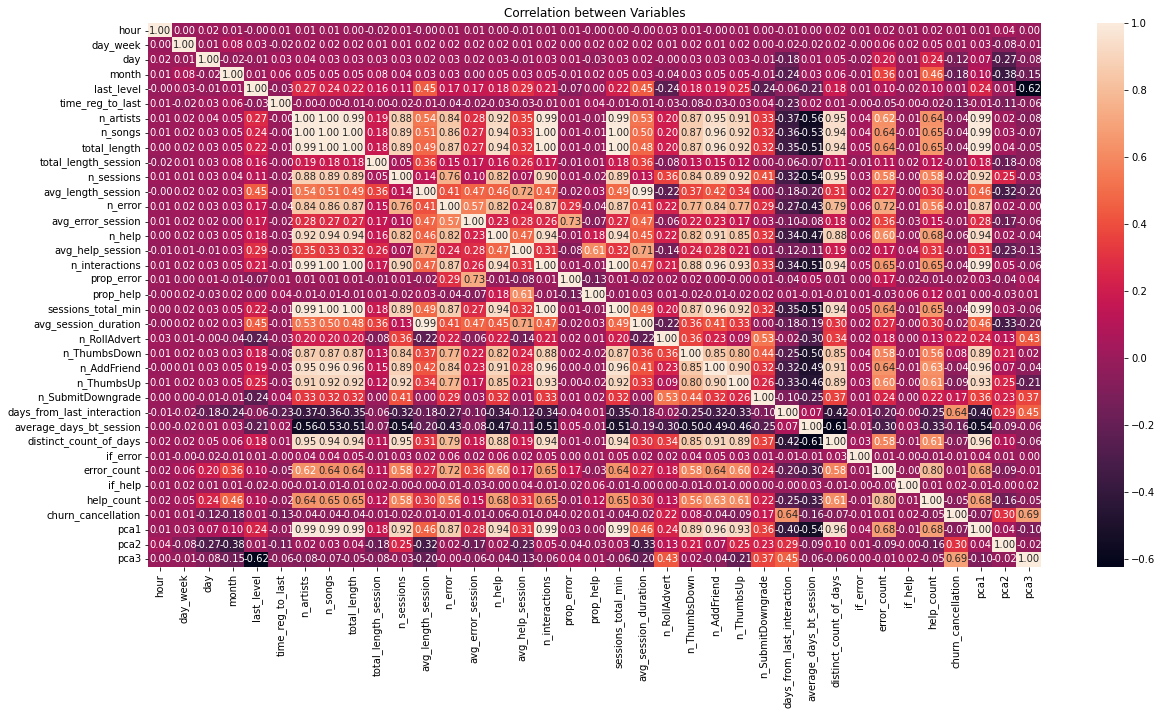

In [ ]:
new_relevant= [#'userId', 'sessionId', 
               'hour', 'day_week', 'day', 'month', 'last_level',
               'time_reg_to_last', 'n_artists', 'n_songs', 'total_length',
               'total_length_session', 'n_sessions', 'avg_length_session', 'n_error',
               'avg_error_session', 'n_help', 'avg_help_session', 'n_interactions',
               'prop_error', 'prop_help', 'sessions_total_min', 'avg_session_duration',
               'n_RollAdvert', 'n_ThumbsDown', 'n_AddFriend', 'n_ThumbsUp',
               'n_SubmitDowngrade', 'days_from_last_interaction',
               'average_days_bt_session', 'distinct_count_of_days', 'if_error',
               'error_count', 'if_help', 'help_count', 'churn_cancellation',
               'pca1', 'pca2', 'pca3']

#Matriz de correlaciones
plt.figure(figsize=(20,10))
sns.heatmap(df[new_relevant].corr(),annot=True, fmt='.2f')
plt.title('Correlation between Variables', fontsize=12)

<font color='mediumblue'>
En la gráfica se observa que hay muchas variables que están fuertemente correlacionadas entre sí. Por ejemplo, como se observó en el TP2, las columnas n_artists, n_songs y total_length estan casi perfectamente correlacionadas entre sí (sus coeficientes de correlación dan próximo a 1). Esto quiere decir que se puede dejar una de ellas sin quitar información significativa al dataset.<br>
A continuación se grafican todas las variables de a pares identificando en cada los puntos que corresponden a usuarios y sesiones que hicieron churn y usuarois y sesiones que no hicieron churn. El objetivo esanalizar si existe alguna combinación de variables que a simple vista permita diferenciar fuertemente las clases.

In [ ]:
n_cols = 5
n_rows = int((len(new_relevant)) // n_cols) + (len(new_relevant) % n_cols > 0)
x = 0
for i, col in enumerate(new_relevant):
    subplot = 0
    fig = plt.figure(figsize=(30, 40))
    for x in range(i,len(new_relevant)):
        subplot = subplot + 1
        ax = fig.add_subplot(n_rows, n_cols, subplot)
        ax.set_title(col + ' vs. ' + new_relevant[x])
        if x == i:
            sns.kdeplot(data=df, x=new_relevant[i], fill=True)#, hue='')
        else:
            sns.scatterplot(data=df.sample(2000), x=new_relevant[i], y=new_relevant[x], hue='churn_cancellation')
    print('*  '*50)
    print(col)
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()   
    plt.close()

Output hidden; open in https://colab.research.google.com to view.

<font color='mediumblue'>
Los gráficos muestran que para algunos pares de variables, los puntos que corresponden a usuarios que hicieron Churn y los que corresponden a usuarios que no hicieron Churn parecen estar agrupandose de forma distinguible. Esto quiere decir que esas variables están aportando información relevante para predecir el churn. A continuación se grafican únicamente esas:
<br>

In [ ]:
#re-check
check_cols = ['prop_error', 'time_reg_to_last', 'help_count', 'pca2', 'pca3'] 
n_cols = 3
n_rows = int((len(check_cols)) // n_cols) + (len(check_cols) % n_cols > 0)
x = 0
for i, col in enumerate(check_cols):
    subplot = 0
    fig = plt.figure(figsize=(30, 10))
    for x in range(0,len(check_cols)):
        subplot = subplot + 1
        ax = fig.add_subplot(n_rows, n_cols, subplot)
        ax.set_title(col + ' vs. ' + check_cols[x])
        if x == i:
            sns.kdeplot(data=df, x=check_cols[i], fill=True)#, hue='')
        else:
            sns.scatterplot(data=df, x=check_cols[i], y=check_cols[x], hue='churn_cancellation')
    print('*  '*50)
    print(col)
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()   
    plt.close()

Output hidden; open in https://colab.research.google.com to view.

<font color='mediumblue'>
Los gráficos muestran que solo algunas de las variables aportan información útil para diferenciar Churn de No Churn. 
<br>
<font color='mediumblue'>
Para resolver el problema de colinealidad entre las variables, se decide eliminar aquellas que muestran una alta correlación de a pares con otras, verificando además que no aporten información útil para separar las clases (en función a los gráficos anteriores).

Text(0.5, 1.0, 'Correlation between Variables')

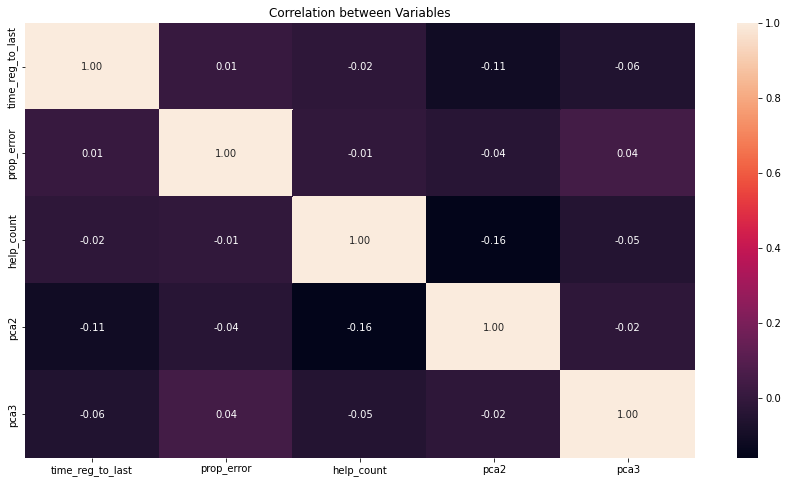

In [ ]:
new_relevant= [#'userId', 'sessionId', 
               #'hour', 'day_week', 'day', 'month', 'last_level',
               'time_reg_to_last',
               #'n_artists', 'n_songs', 'total_length',
               #'total_length_session', 'n_sessions', 'avg_length_session',
               #'n_error', 'avg_error_session', 'n_help', 'avg_help_session', 'n_interactions',
               'prop_error',
               #'prop_help', 'sessions_total_min', 'avg_session_duration',
               #'n_RollAdvert', 'n_ThumbsDown', 'n_AddFriend', 'n_ThumbsUp',
               #'n_SubmitDowngrade',
               #'days_from_last_interaction', 
               #'average_days_bt_session',
               #'distinct_count_of_days', 'if_error',
               #'error_count','if_help',
               'help_count',
               #'churn_cancellation', 'pca1',
               'pca2', 'pca3']

#Matriz de correlaciones
plt.figure(figsize=(15,8))
sns.heatmap(df[new_relevant].corr(),annot=True, fmt='.2f')
plt.title('Correlation between Variables', fontsize=12)

<font color='mediumblue'>
La matriz de correlación resultante ahora muestra correlaciones bajas para todas las variables seleccionadas entre sí.
<br>
Una vez definido el conjunto de variables con las que se va a trabajar, se dividirán los casos entre Train, Test y Validation.

In [ ]:
X = df[new_relevant]

In [ ]:
Y = df.churn_cancellation.astype('int')
# X = df.drop(columns='churn_cancellation',axis=1)

<font color='mediumblue'>
Se va a diviir el conjunto de datos para lograr 3 subconjuntos:<br>
    - Train: 70% de los datos<br>
    - Test: 20% de los datos<br>
    - Validation: 10% de los datos

In [ ]:
#Separacion entre train y validation (10% de los datos)
x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 0, stratify=Y)

#Nuevamente se divide el conjunto train para así obtener el de train y test (aprox. 78% del total de datos de train representan el 70% del total de datos original)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.78, random_state = 0, stratify=y_train)

###i. Analizar las proporciones consideradas para cada conjunto con respecto al total del dataset. Verificar el total de datos de cada conjunto. (usar stratisfied)


In [ ]:
print(f'''
Registros totales: {df.shape[0]}
train: {x_train.shape[0]} ({round(x_train.shape[0]/df.shape[0],2)*100}%)
test: {x_test.shape[0]} ({round(x_test.shape[0]/df.shape[0],2)*100}%)
validation: {x_val.shape[0]} ({round(x_val.shape[0]/df.shape[0],2)*100}%)
''')


Registros totales: 6056
train: 4251 (70.0%)
test: 1199 (20.0%)
validation: 606 (10.0%)



<font color='mediumblue'>
Se logra la proporción de datos propuesta para cada conjunto.

###ii. Para cada conjunto (train, test, val), ¿cuántos datos de cada clase target hay (churn y no churn)?, se debe buscar mantener la proporción del dataset total (el desbalanceo que era casi de 3 a 1).

Text(0.5, 1.0, 'Validation set')

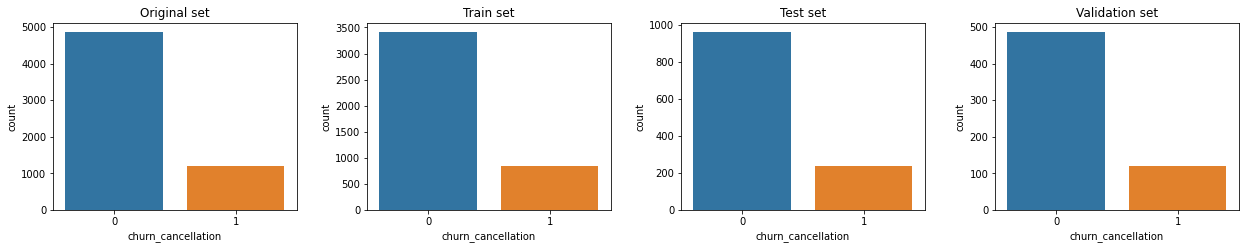

In [ ]:
orig = pd.DataFrame(Y)
train = pd.DataFrame(y_train)
test = pd.DataFrame(y_test)
val = pd.DataFrame(y_val)

fig, ax = plt.subplots(ncols=4, figsize=(18,4), sharey=False)
fig.tight_layout(pad=4)
sns.countplot(x='churn_cancellation', data=orig, ax=ax[0])
ax[0].set_title('Original set')
sns.countplot(x='churn_cancellation', data=train, ax=ax[1])
ax[1].set_title('Train set')
sns.countplot(x='churn_cancellation', data=test, ax=ax[2])
ax[2].set_title('Test set')
sns.countplot(x='churn_cancellation', data=val, ax=ax[3])
ax[3].set_title('Validation set')

<font color='mediumblue'>
Como se puede ver, se mantiene la proporción de cada clase en los distintos subconjuntos de datos.

#2. Creación de un modelo baseline
##a. Entrenar un modelo “baseline”, es decir lo más simple posible, para con ello tener un punto de partida con el cual comparar modelos más complejos.
(Hint: se puede usar por ejemplo la clase “DummyClassifier” de scikit-learn)

Documentación:
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
Hint: fijar la semilla aleatoria para hacer repetible el experimento.

In [ ]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=0)
dummy_clf.fit(x_train, y_train)
y_train_pred = dummy_clf.predict(x_train)
y_test_pred = dummy_clf.predict(x_test)
y_val_pred = dummy_clf.predict(x_val)

##b. Evaluar sobre el conjunto de entrenamiento, validación y test reportando:
a. Accuracy
b. Precision
c. Recall
d. F1
e. Matriz de confusión

a)
Accuracy train: 68.62%
Accuracy test: 67.31%
Accuracy val: 68.48%
b)
Precision train: 20.45%
Precision test: 17.70%
Precision val: 20.00%
c)
Recall train: 20.74%
Recall test: 18.30%
Recall val: 20.17%
d)
F1 train: 20.60%
F1 test: 17.99%
F1 val: 20.08%
e)


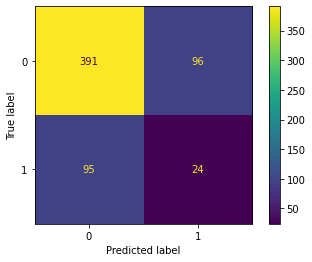

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       487
           1       0.20      0.20      0.20       119

    accuracy                           0.68       606
   macro avg       0.50      0.50      0.50       606
weighted avg       0.69      0.68      0.69       606



In [ ]:
print('a)')
accuracy = accuracy_score(y_train,y_train_pred)
print(f"Accuracy train: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_test,y_test_pred)
print(f"Accuracy test: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_val,y_val_pred)
print(f"Accuracy val: %.2f%%" % (accuracy * 100.0))
print('b)')
precision = precision_score(y_train,y_train_pred)
print(f"Precision train: %.2f%%" % (precision * 100.0))
precision = precision_score(y_test,y_test_pred)
print(f"Precision test: %.2f%%" % (precision * 100.0))
precision = precision_score(y_val,y_val_pred)
print(f"Precision val: %.2f%%" % (precision * 100.0))   
print('c)')
recall = recall_score(y_train,y_train_pred)
print(f"Recall train: %.2f%%" % (recall * 100.0))
recall = recall_score(y_test,y_test_pred)
print(f"Recall test: %.2f%%" % (recall * 100.0))
recall = recall_score(y_val,y_val_pred)
print(f"Recall val: %.2f%%" % (recall * 100.0))   
print('d)')
f1 = f1_score(y_train,y_train_pred)
print(f"F1 train: %.2f%%" % (f1 * 100.0))
f1 = f1_score(y_test,y_test_pred)
print(f"F1 test: %.2f%%" % (f1 * 100.0))
f1 = f1_score(y_val,y_val_pred)
print(f"F1 val: %.2f%%" % (f1 * 100.0))    
print('e)')
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.show()
print(classification_report(y_val, y_val_pred))

<font color='mediumblue'>
Como era de esperar, los resultados con el modelo baseline requieren grandes mejoras para predecir correctamente los casos de Churn.

##c. Pensar cuál métrica es conveniente optimizar en éste problema de clasificación donde se predice churn. ¿Sería el Accuracy una buena métrica?

<font color='mediumblue'>
La métrica más conveniente parece ser la "recall", que se centra en los casos positivos verdaderos sobre el total de casos positivos reales. En este caso, es mucho más importante predecir correctamente un posible churn, frente a marcar como chrun a un cliente que no iba a tomar esa decisión.<br>
En cambio, "accuracy" no es una buena métrica para este caso porque no es apropiada para los problemas de predicción donde hay una desbalanceo importante de las clases. Podría dar valores aceptables basados en la predicción de la clase mayoritaria (la que es predicha por el modelo la mayoría de las veces), mientras las predicciones para la clase restante podrían estar muy equivocadas.

#3. Predicción de modelos lineales

##a. Entrenar modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar “LogisticRegression” de scikit-learn.
Y elegir al menos uno de los siguientes otros modelosr:

i. La clase SGDClassifier de scikit-learn.

ii. La clase LinearSVC de scikit-learn.

Documentación:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/sgd.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

Hint: fijar la semilla aleatoria para hacer repetible el experimento.

###LogisticRegression

In [ ]:
LR = LogisticRegression(random_state=0, max_iter=2000)
LR.fit(x_train, y_train)

LogisticRegression(max_iter=2000, random_state=0)

###SGDClassifier

In [ ]:
SGD = SGDClassifier(random_state=0)
SGD.fit(x_train, y_train)

SGDClassifier(random_state=0)

###LinearSVC

In [ ]:
LSVC = LinearSVC(random_state=0)
LSVC.fit(x_train, y_train)

LinearSVC(random_state=0)

##b. Evaluar sobre el conjunto de entrenamiento, validación y test reportando:
iii. Accuracy
iv. Precision
v. Recall
vi. F1
vii. Matriz de confusión

Logistic Regression
Accuracy train: 95.18%
Accuracy test: 95.08%
Accuracy val: 94.06%
Precision train: 90.06%
Precision test: 90.00%
Precision val: 88.79%
Recall train: 84.77%
Recall test: 84.26%
Recall val: 79.83%
F1 train: 87.34%
F1 test: 87.03%
F1 val: 84.07%


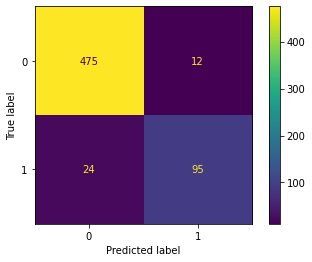

----------------------------------------
SGD Classifier
Accuracy train: 95.20%
Accuracy test: 94.91%
Accuracy val: 93.89%
Precision train: 90.70%
Precision test: 89.91%
Precision val: 88.68%
Recall train: 84.17%
Recall test: 83.40%
Recall val: 78.99%
F1 train: 87.31%
F1 test: 86.53%
F1 val: 83.56%


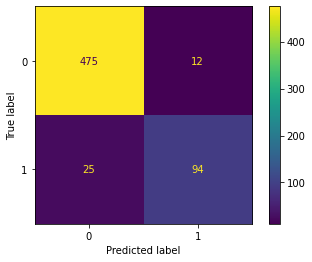

----------------------------------------
Linear Support Vector Classification
Accuracy train: 95.04%
Accuracy test: 94.66%
Accuracy val: 93.73%
Precision train: 88.60%
Precision test: 87.01%
Precision val: 86.49%
Recall train: 85.73%
Recall test: 85.53%
Recall val: 80.67%
F1 train: 87.14%
F1 test: 86.27%
F1 val: 83.48%


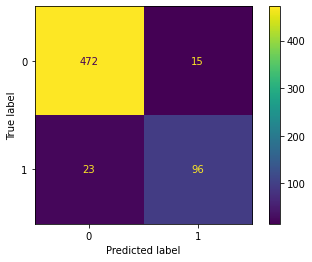

----------------------------------------


In [ ]:
clfs = [LR, SGD, LSVC]
names = ['Logistic Regression', 'SGD Classifier', 'Linear Support Vector Classification']
for clf,name in zip(clfs,names):
    print(name)
    y_train_pred = clf.predict(x_train)
    y_test_pred = clf.predict(x_test)
    y_val_pred = clf.predict(x_val)
    accuracy = accuracy_score(y_train,y_train_pred)
    print(f"Accuracy train: %.2f%%" % (accuracy * 100.0))
    accuracy = accuracy_score(y_test,y_test_pred)
    print(f"Accuracy test: %.2f%%" % (accuracy * 100.0))
    accuracy = accuracy_score(y_val,y_val_pred)
    print(f"Accuracy val: %.2f%%" % (accuracy * 100.0))    
    precision = precision_score(y_train,y_train_pred)
    print(f"Precision train: %.2f%%" % (precision * 100.0))
    precision = precision_score(y_test,y_test_pred)
    print(f"Precision test: %.2f%%" % (precision * 100.0))
    precision = precision_score(y_val,y_val_pred)
    print(f"Precision val: %.2f%%" % (precision * 100.0))    
    recall = recall_score(y_train,y_train_pred)
    print(f"Recall train: %.2f%%" % (recall * 100.0))
    recall = recall_score(y_test,y_test_pred)
    print(f"Recall test: %.2f%%" % (recall * 100.0))
    recall = recall_score(y_val,y_val_pred)
    print(f"Recall val: %.2f%%" % (recall * 100.0))    
    f1 = f1_score(y_train,y_train_pred)
    print(f"F1 train: %.2f%%" % (f1 * 100.0))
    f1 = f1_score(y_test,y_test_pred)
    print(f"F1 test: %.2f%%" % (f1 * 100.0))
    f1 = f1_score(y_val,y_val_pred)
    print(f"F1 val: %.2f%%" % (f1 * 100.0))    
    ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
    plt.show()
    print('-'*40)

##c. Elabore conclusiones en base a la métrica a optimizar y compare con el modelo baseline.

<font color='mediumblue'>
Para evaluar los modelos se considera la medida de Recall para el grupo de Test, ya que el de entrenamiento es el que se está usando para ajustar el modelo, y el de validación se agrega a modo informativo,y no debería considerarse hasta tener el modelo final.<br>
De los tres modelos lineales, el Liner Support Vector Classification (LVSC) es el que arroja los mejores resultados en relación al Recall (85.53% para el grupo Test). Dicha medida es un 2.55% mas alto que la misma medida para el modelo SGD Classifier (83.40%) y 1.51% mas alto que para el modelo LogisticRegression (84.26%). 
<br>
Además, el Recall del modelo LVSC es un 383% más alto que la misma medida para el modelo baseline (18.30%).

#4. Predicción de modelos basados en árboles de decisión

##a. Para ello, deberán elegir al menos dos de los siguientes modelos:

i. La clase DecisionTreeClassifier de scikit-learn.

ii. La clase RandomForestClassifier de scikit-learn.

iii. La clase GradientBoostingClassifier de scikit-learn.

Documentación:
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomF
orestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

Hint: fijar la semilla aleatoria para hacer repetible el experimento.

###DecisionTreeClassifier

In [ ]:
DTC = DecisionTreeClassifier(random_state=0)
DTC.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

###RandomForestClassifier

In [ ]:
RFC = RandomForestClassifier(random_state=0)
RFC.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

###GradientBoostingClassifier

In [ ]:
GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(x_train, y_train)

GradientBoostingClassifier(random_state=0)

##b. Evaluar sobre el conjunto de entrenamiento, validación y test reportando:
i. Accuracy
ii. Precision
iii. Recall
iv. F1
v. Matriz de confusión

Decision Tree Classifier
Accuracy train: 100.00%
Accuracy test: 99.42%
Accuracy val: 99.67%
Precision train: 100.00%
Precision test: 97.90%
Precision val: 99.16%
Recall train: 100.00%
Recall test: 99.15%
Recall val: 99.16%
F1 train: 100.00%
F1 test: 98.52%
F1 val: 99.16%


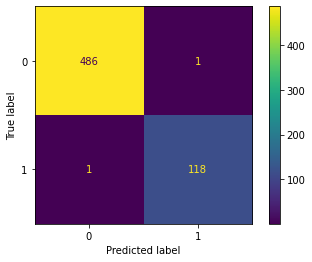

----------------------------------------
Random Forest Classifier
Accuracy train: 100.00%
Accuracy test: 99.75%
Accuracy val: 99.17%
Precision train: 100.00%
Precision test: 100.00%
Precision val: 100.00%
Recall train: 100.00%
Recall test: 98.72%
Recall val: 95.80%
F1 train: 100.00%
F1 test: 99.36%
F1 val: 97.85%


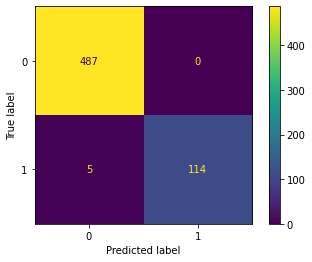

----------------------------------------
Gradient Boosting Classifier
Accuracy train: 99.84%
Accuracy test: 99.42%
Accuracy val: 99.34%
Precision train: 99.88%
Precision test: 100.00%
Precision val: 100.00%
Recall train: 99.28%
Recall test: 97.02%
Recall val: 96.64%
F1 train: 99.58%
F1 test: 98.49%
F1 val: 98.29%


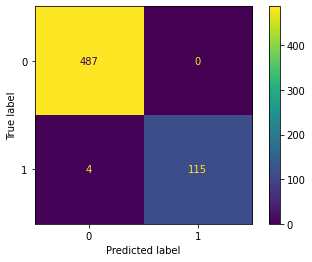

----------------------------------------


In [ ]:
clfs = [DTC, RFC, GBC]
names = ['Decision Tree Classifier', 'Random Forest Classifier', 'Gradient Boosting Classifier']
for clf,name in zip(clfs,names):
    print(name)
    y_train_pred = clf.predict(x_train)
    y_test_pred = clf.predict(x_test)
    y_val_pred = clf.predict(x_val)
    accuracy = accuracy_score(y_train,y_train_pred)
    print(f"Accuracy train: %.2f%%" % (accuracy * 100.0))
    accuracy = accuracy_score(y_test,y_test_pred)
    print(f"Accuracy test: %.2f%%" % (accuracy * 100.0))
    accuracy = accuracy_score(y_val,y_val_pred)
    print(f"Accuracy val: %.2f%%" % (accuracy * 100.0))    
    precision = precision_score(y_train,y_train_pred)
    print(f"Precision train: %.2f%%" % (precision * 100.0))
    precision = precision_score(y_test,y_test_pred)
    print(f"Precision test: %.2f%%" % (precision * 100.0))
    precision = precision_score(y_val,y_val_pred)
    print(f"Precision val: %.2f%%" % (precision * 100.0))    
    recall = recall_score(y_train,y_train_pred)
    print(f"Recall train: %.2f%%" % (recall * 100.0))
    recall = recall_score(y_test,y_test_pred)
    print(f"Recall test: %.2f%%" % (recall * 100.0))
    recall = recall_score(y_val,y_val_pred)
    print(f"Recall val: %.2f%%" % (recall * 100.0))    
    f1 = f1_score(y_train,y_train_pred)
    print(f"F1 train: %.2f%%" % (f1 * 100.0))
    f1 = f1_score(y_test,y_test_pred)
    print(f"F1 test: %.2f%%" % (f1 * 100.0))
    f1 = f1_score(y_val,y_val_pred)
    print(f"F1 val: %.2f%%" % (f1 * 100.0))
    ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
    plt.show()
    print('-'*40)

##c. Elabore conclusiones en base a la métrica a optimizar, comparando los modelos elegidos y contrastando con el modelo lineal elegido.

<font color='mediumblue'>
De los tres modelos basados en árboles de decisión, el Decision Tree Classifier (DTC) es el que arroja los mejores resultados en relación al Recall del grupo Test (99.15%). Sin embargo, dicha medida para el grupo de entrenamiento da 100% (al igual que las otras 3 medidas). Lo mismo sucede con el modelo Random Forest Classifier: sus cuatro medidas en el grupo de entrenamiento dan 100%. Esto parece poco realista y se corre riesgo de estar sobreajustando el modelo.
<br>
Por esta razón, se optará por el modelo Gradient Boosting Classifier, que también obtuvo excelentes resultados, pero muestra margen para mejorar el Recall tanto en el grupo de Train como en el de Test con un ajuste de hiperparámetros.
<br>
Sin embargo, como los resultados de los tres modelos son similares, se ajustarán los tres por hiperparámetros para evaluar los resultados.

#5. Ajuste por hiperparámetros

## a. Para los dos “mejores modelos” obtenidos en los puntos anteriores, seleccionar valores para los hiperparámetros principales de dichos modelos (ajustar con por lo menos 3 parámetros). Utilizar grid-search y k-fold cross-validation.

<font color='mediumblue'>
Como se mencionó en el punto anterior, se ajustaran los 3 modelos por hiperparámetros. Primero se agrupan nuevamente los datos de train y test para hacer el ajuste por hiperparámetros.

In [ ]:
#Es necesario conocer la versión de sklearn que estamos utilizando para acudir a la documentación que corresponda a esa versión
import sklearn
print(f'la versión de scikit-learn es {sklearn.__version__}.')

la versión de scikit-learn es 1.0.2.


In [ ]:
#Se transforma el dataframe de pandas en un array
#Se excluye el set de validación para que el modelo "no lo vea" hasta evaluar las predicciones
x = pd.concat([x_train, x_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
x_arr = np.array(x)
y_arr = np.array(y)

###Decision Tree Classifier

<font color='mediumblue'>
Para este modelo, se probarán dos criterios de medición de la calidad de la partición (gini y entropy), dos estrategias para elegir entre cada partición y nodo (best y random), tres alternativas para el número máximo de características tenidas en cuenta, y cinco alternativas de profundidad del árbol. Esto devuelve 60 combinaciones posibles.

In [ ]:
#Grilla de parámetros
param_grid_DTC = {
                'criterion': ['gini', 'entropy'],# 'log_loss'], #criterio de partición. 
                'splitter': ['best','random'],
                'max_features':['auto','sqrt','log2'],
                'max_depth': [3, 6, 12, 24, 48]#, #máxima profundidad de cada estimador
                }
print(f'Combinaciones posibles: {len(ParameterGrid(param_grid_DTC))}')

Combinaciones posibles: 60


<font color='mediumblue'>
A continuación se ejecuta el grid search para determinar la mejor combinación de parámetros entre las 60.

In [ ]:
#Búsqueda de la mejor combinación de parámetros
clf_DTC = DecisionTreeClassifier(random_state=0)
grid_cv_DTC = GridSearchCV(clf_DTC, param_grid_DTC, scoring='recall', cv=5) #como el estimador es un clasificador y las clases son binarias, se aplica StratifiedKFold
grid_cv_DTC.fit(x_arr,y_arr)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 12, 24, 48],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='recall')

###RandomForestClassifier
Documentación: [RandomForestClassifier > scikit-learn 1.0.2](https://scikit-learn.org/1.0/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

<font color='mediumblue'>
En el caso de Random Forest Classifier, se probarán también los dos criterios de partición que se probaron para DTC. Además, se probarán 3 cantidades diferentes de estimadores (árboles), 3 profundidades del árbol y 3 cantidades mínimas de muestras para considerar un nodo como tal. Esto resulta en 54 combinaciones posibles a ser evaluadas.

In [ ]:
#Grilla de parámetros
param_grid_RFC = {
                'criterion': ['gini', 'entropy'],   #criterio de partición
                'n_estimators': [50, 100, 150], #numero de arboles
                'max_depth'   : [10, 20, 50], #maxima profundidad del arbol
                'min_samples_leaf': [2,3,4],    #cantidad mínima de samples por hoja
                }
print(f'Combinaciones posibles: {len(ParameterGrid(param_grid_RFC))}')

Combinaciones posibles: 54


<font color='mediumblue'>
A continuación se ejecuta el grid search para determinar la mejor combinación de parámetros entre las 54.

In [ ]:
#Búsqueda de la mejor combinación de parámetros
clf_RFC = RandomForestClassifier(random_state=0)
grid_cv_RFC = GridSearchCV(clf_RFC, param_grid_RFC, scoring='recall', cv=5) #como el estimador es un clasificador y las clases son binarias, se aplica StratifiedKFold
grid_cv_RFC.fit(x_arr,y_arr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 50],
                         'min_samples_leaf': [2, 3, 4],
                         'n_estimators': [50, 100, 150]},
             scoring='recall')

###GradientBoostingClassifier
Documentación: [GradientBoostingClassifier > scikit-learn 1.0.2](https://scikit-learn.org/1.0/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)

<font color='mediumblue'>
Por último, para el modelo GBC, se probarán dos funciones de pérdida, 3 tasas de aprendizaje, 3 números de estimadores, 3 profundidades y dos criterios de partición. Esto resulta en un total de 108 combinaciones posibles a ser evaluadas.

In [ ]:
#Grilla de parámetros
param_grid_GBC = {
                'loss': ['deviance', 'exponential'], #función de pérdida
                'learning_rate': [0.01, 0.1, 0.2], #tasa de aprendizaje
                'n_estimators': [10, 20, 30], #numero de estimadores
                'max_depth': [3, 6, 20], #máxima profundidad de cada estimador
                'criterion': ['friedman_mse', 'squared_error'], #criterio de partición
                }
print(f'Combinaciones posibles: {len(ParameterGrid(param_grid_GBC))}')

Combinaciones posibles: 108


<font color='mediumblue'>
A continuación se ejecuta el grid search para determinar la mejor combinación de parámetros entre las 108.

In [ ]:
#Búsqueda de la mejor combinación de parámetros
clf_GBC = GradientBoostingClassifier(random_state=0)
grid_cv_GBC = GridSearchCV(clf_GBC, param_grid_GBC, scoring='recall', cv=5) #como el estimador es un clasificador y las clases son binarias, se aplica StratifiedKFold
grid_cv_GBC.fit(x_arr,y_arr)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'loss': ['deviance', 'exponential'],
                         'max_depth': [3, 6, 20],
                         'n_estimators': [10, 20, 30]},
             scoring='recall')

## b. Mencionar el mejor modelo obtenido de la Optimización de Hiperparámetros y con cuáles parámetros se obtuvo ese resultado.

<font color='mediumblue'>
Como se explicó antes, el modelo que se había considerado como mejor de todos era Gradient Boosting Classifier. Para dicho modelo, se evaluaron 108 combinaciones de parámetros. Sin embargo, se verán los resultados del ajuste por hiperparámetros para los tres modelos analizados.

###Decision Tree Classifier

In [ ]:
#Resultados
resultados_DTC = pd.DataFrame(grid_cv_DTC.cv_results_)[['param_criterion','param_splitter','param_max_features','param_max_depth','std_test_score','rank_test_score']]
print('Los 7 mejores resultados')
resultados_DTC.rename_axis('index').sort_values(by = ['rank_test_score', 'index'], ascending = [True, True]).head(7)

Los 7 mejores resultados


,param_criterion,param_splitter,param_max_features,param_max_depth,std_test_score,rank_test_score
index,,,,,,
48,entropy,best,auto,24,0.011645,1
50,entropy,best,sqrt,24,0.011645,1
52,entropy,best,log2,24,0.011645,1
54,entropy,best,auto,48,0.011645,1
56,entropy,best,sqrt,48,0.011645,1
58,entropy,best,log2,48,0.011645,1
18,gini,best,auto,24,0.003502,7


<font color='mediumblue'>
Como resultado del Grid Search en DTC, las mejores 6 combinaciones fueron rankeadas con el mismo puntaje. Esto quiere decir que dichas combinaciones son igualmente óptimas para predecir el Churn con el modelo DTC. A continuación se ajustará el modelo con la primera de esas combinaciones.

In [ ]:
#Mejor combinación de parámetros GBC
best_p_DTC = grid_cv_DTC.best_params_
best_p_DTC

{'criterion': 'entropy',
 'max_depth': 24,
 'max_features': 'auto',
 'splitter': 'best'}

In [ ]:
#Modelo
clf_DTC_best = DecisionTreeClassifier(**best_p_DTC, random_state=0)
clf_DTC_best


DecisionTreeClassifier(criterion='entropy', max_depth=24, max_features='auto',
                       random_state=0)

###RandomForestClassifier

In [ ]:
#Resultados
resultados_RFC = pd.DataFrame(grid_cv_RFC.cv_results_)[['param_criterion','param_max_depth','param_min_samples_leaf','param_n_estimators','std_test_score','rank_test_score']]
print('Los 5 mejores resultados')
resultados_RFC.rename_axis('index').sort_values(by = ['rank_test_score', 'index'], ascending = [True, True]).head(5)

Los 5 mejores resultados


,param_criterion,param_max_depth,param_min_samples_leaf,param_n_estimators,std_test_score,rank_test_score
index,,,,,,
37,entropy,20,2,100,0.009627,1
38,entropy,20,2,150,0.009627,1
46,entropy,50,2,100,0.009627,1
47,entropy,50,2,150,0.009627,1
27,entropy,10,2,50,0.011216,5


<font color='mediumblue'>
En el caso de RFC, las primeras 4 filas de la tabla son las mejores combinaciones, rankeadas con el mismo puntaje. A continuación se ajustará el modelo con la primera de esas combinaciones.

In [ ]:
#Mejor combinación de parámetros
best_p_RFC = grid_cv_RFC.best_params_
best_p_RFC

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [ ]:
#Modelo
clf_RFC_best = RandomForestClassifier(**best_p_RFC, random_state=0)
clf_RFC_best

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=2,
                       random_state=0)

###GradientBoostingClassifier (Mejor modelo)

In [ ]:
#Resultados
resultados_GBC = pd.DataFrame(grid_cv_GBC.cv_results_)[['param_criterion','param_learning_rate','param_loss','param_max_depth','param_n_estimators','mean_test_score','std_test_score','rank_test_score']]
print('Los 5 mejores resultados')
resultados_GBC.rename_axis('index').sort_values(by = ['rank_test_score', 'index'], ascending = [True, True]).head(5)

Los 5 mejores resultados


,param_criterion,param_learning_rate,param_loss,param_max_depth,param_n_estimators,mean_test_score,std_test_score,rank_test_score
index,,,,,,,,
26,friedman_mse,0.1,deviance,20,30,0.986907,0.008035,1
79,squared_error,0.1,deviance,20,20,0.986907,0.008035,1
80,squared_error,0.1,deviance,20,30,0.986907,0.008035,1
25,friedman_mse,0.1,deviance,20,20,0.985973,0.007234,4
34,friedman_mse,0.1,exponential,20,20,0.985973,0.007234,4


<font color='mediumblue'>
En el caso del GBC, los primeros 3 resultados fueron rankeados igualmente como mejores combinaciones de parámetros. Se ajustará el modelo con la primera de esas combinaciones:

In [ ]:
#Mejor combinación de parámetros GBC
best_p_GBC = grid_cv_GBC.best_params_
best_p_GBC

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 20,
 'n_estimators': 30}

In [ ]:
#Modelo
clf_GBC_best = GradientBoostingClassifier(**best_p_GBC, random_state=0)
clf_GBC_best

GradientBoostingClassifier(max_depth=20, n_estimators=30, random_state=0)

## c. Con el mejor modelo obtenido realizar las predicciones sobre test y val.

<font color='mediumblue'>
Pese a que se había decidido optar por el modelo Gradient Boosting Classifier, se decidió realizar las predicciones con todos los modelos para realizar un análisis más extensivo.

###GradientBoostingClassifier (Mejor modelo)

In [ ]:
#Entrenamiento del modelo con hiperparámetros seleccionados
clf_GBC_best.fit(x_train, y_train)
y_train_pred_GBC_best = clf_GBC_best.predict(x_train)
y_test_pred_GBC_best = clf_GBC_best.predict(x_test)
y_val_pred_GBC_best = clf_GBC_best.predict(x_val)

###RandomForestClassifier

In [ ]:
#Entrenamiento del modelo con hiperparámetros seleccionados
clf_RFC_best.fit(x_train, y_train)
y_train_pred_RFC_best = clf_RFC_best.predict(x_train)
y_test_pred_RFC_best = clf_RFC_best.predict(x_test)
y_val_pred_RFC_best = clf_RFC_best.predict(x_val)

###Decision Tree Classifier


In [ ]:
#Entrenamiento del modelo con hiperparámetros seleccionados
clf_DTC_best.fit(x_train, y_train)
y_train_pred_DTC_best = clf_DTC_best.predict(x_train)
y_test_pred_DTC_best = clf_DTC_best.predict(x_test)
y_val_pred_DTC_best = clf_DTC_best.predict(x_val)

## d. Reportar las métricas del mejor modelo, incluyendo las matrices de confusión. Comparar el mejor modelo obtenido, con el modelo con parámetros por defecto y con el modelo baseline. Elabore conclusiones al respecto pensando en la resolución de nuestro problema de clasificación.

<font color='mediumblue'>
Luego de haber entrenado los modelos y calculado las etiquetas predichas para cada modelo, se procederá a la evaluación de los modelos con las métricas Accuaracy, Precision, Recall, y F1 Score, haciendo hincapié en el Recall (métrica a optimizar).


###RandomForestClassifier

Accuracy train: 100.00%
Accuracy test: 99.75%
Accuracy val: 99.17%
Precision train: 100.00%
Precision test: 100.00%
Precision val: 100.00%
Recall train: 100.00%
Recall test: 98.72%
Recall val: 95.80%
F1 train: 100.00%
F1 test: 99.36%
F1 val: 97.85%


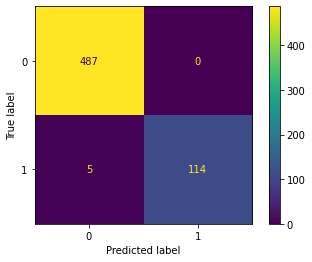

In [ ]:
accuracy = accuracy_score(y_train,y_train_pred_RFC_best)
print(f"Accuracy train: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_test,y_test_pred_RFC_best)
print(f"Accuracy test: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_val,y_val_pred_RFC_best)
print(f"Accuracy val: %.2f%%" % (accuracy * 100.0))    
precision = precision_score(y_train,y_train_pred_RFC_best)
print(f"Precision train: %.2f%%" % (precision * 100.0))
precision = precision_score(y_test,y_test_pred_RFC_best)
print(f"Precision test: %.2f%%" % (precision * 100.0))
precision = precision_score(y_val,y_val_pred_RFC_best)
print(f"Precision val: %.2f%%" % (precision * 100.0))    
recall = recall_score(y_train,y_train_pred_RFC_best)
print(f"Recall train: %.2f%%" % (recall * 100.0))
recall = recall_score(y_test,y_test_pred_RFC_best)
print(f"Recall test: %.2f%%" % (recall * 100.0))
recall = recall_score(y_val,y_val_pred_RFC_best)
print(f"Recall val: %.2f%%" % (recall * 100.0))    
f1 = f1_score(y_train,y_train_pred_RFC_best)
print(f"F1 train: %.2f%%" % (f1 * 100.0))
f1 = f1_score(y_test,y_test_pred_RFC_best)
print(f"F1 test: %.2f%%" % (f1 * 100.0))
f1 = f1_score(y_val,y_val_pred_RFC_best)
print(f"F1 val: %.2f%%" % (f1 * 100.0))
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_RFC_best)

<font color='mediumblue'>
En el caso de RFC, a pesar de haber llevado a cabo un ajuste por hiperparámetros, los resultados obtenidos son los mismos que con el modelo que se ajustó con los parámetros por defecto (todas las métricas dan igual para los tres conjuntos de datos). <br>
En comparación con el modelo baseline, no obstante, las mejoras son significativas. Particularmente el Recall para el conjunto de Test en el modelo RFC es más de 5 veces el del modelo baseline (99.15% vs 18.30%).

###DecisionTreeClassifier

Accuracy train: 100.00%
Accuracy test: 99.25%
Accuracy val: 98.84%
Precision train: 100.00%
Precision test: 98.29%
Precision val: 97.46%
Recall train: 100.00%
Recall test: 97.87%
Recall val: 96.64%
F1 train: 100.00%
F1 test: 98.08%
F1 val: 97.05%


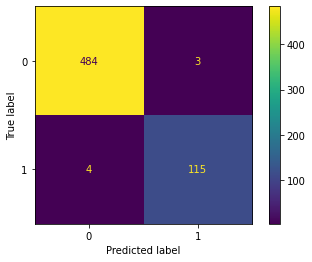

In [ ]:
accuracy = accuracy_score(y_train,y_train_pred_DTC_best)
print(f"Accuracy train: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_test,y_test_pred_DTC_best)
print(f"Accuracy test: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_val,y_val_pred_DTC_best)
print(f"Accuracy val: %.2f%%" % (accuracy * 100.0))    
precision = precision_score(y_train,y_train_pred_DTC_best)
print(f"Precision train: %.2f%%" % (precision * 100.0))
precision = precision_score(y_test,y_test_pred_DTC_best)
print(f"Precision test: %.2f%%" % (precision * 100.0))
precision = precision_score(y_val,y_val_pred_DTC_best)
print(f"Precision val: %.2f%%" % (precision * 100.0))    
recall = recall_score(y_train,y_train_pred_DTC_best)
print(f"Recall train: %.2f%%" % (recall * 100.0))
recall = recall_score(y_test,y_test_pred_DTC_best)
print(f"Recall test: %.2f%%" % (recall * 100.0))
recall = recall_score(y_val,y_val_pred_DTC_best)
print(f"Recall val: %.2f%%" % (recall * 100.0))    
f1 = f1_score(y_train,y_train_pred_DTC_best)
print(f"F1 train: %.2f%%" % (f1 * 100.0))
f1 = f1_score(y_test,y_test_pred_DTC_best)
print(f"F1 test: %.2f%%" % (f1 * 100.0))
f1 = f1_score(y_val,y_val_pred_DTC_best)
print(f"F1 val: %.2f%%" % (f1 * 100.0))
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_DTC_best)

<font color='mediumblue'>
El modelo DTC también mejora significativamente el modelo baseline. El Recall del conjunto de Test es de 97.87%, que también es más de 5 veces el Recall obtenido para dicho conjunto con el modelo Dummy Classifier. <br>
Sin embargo, la versión de DTC ajustada por hiperparámetros obtuvo valores de recall más bajos que el modelo con los parámetros por defecto. Particularmente el Recall baja un 1.29% para el conjunto de Test. Esto puede explicarse porque el Grid Search toma Test y Train para optimizar, pero cuando se hace el entrenamiento solo se consideran los datos del conjunto Train.<br>

###GradientBoostingClassifier (Modelo Elegido)

Accuracy train: 100.00%
Accuracy test: 99.50%
Accuracy val: 99.67%
Precision train: 100.00%
Precision test: 98.31%
Precision val: 99.16%
Recall train: 100.00%
Recall test: 99.15%
Recall val: 99.16%
F1 train: 100.00%
F1 test: 98.73%
F1 val: 99.16%


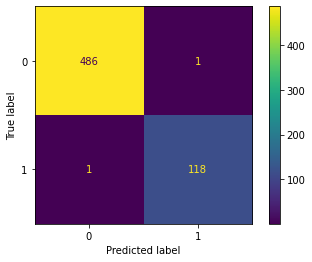

In [ ]:
accuracy = accuracy_score(y_train,y_train_pred_GBC_best)
print(f"Accuracy train: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_test,y_test_pred_GBC_best)
print(f"Accuracy test: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_val,y_val_pred_GBC_best)
print(f"Accuracy val: %.2f%%" % (accuracy * 100.0))    
precision = precision_score(y_train,y_train_pred_GBC_best)
print(f"Precision train: %.2f%%" % (precision * 100.0))
precision = precision_score(y_test,y_test_pred_GBC_best)
print(f"Precision test: %.2f%%" % (precision * 100.0))
precision = precision_score(y_val,y_val_pred_GBC_best)
print(f"Precision val: %.2f%%" % (precision * 100.0))    
recall = recall_score(y_train,y_train_pred_GBC_best)
print(f"Recall train: %.2f%%" % (recall * 100.0))
recall = recall_score(y_test,y_test_pred_GBC_best)
print(f"Recall test: %.2f%%" % (recall * 100.0))
recall = recall_score(y_val,y_val_pred_GBC_best)
print(f"Recall val: %.2f%%" % (recall * 100.0))    
f1 = f1_score(y_train,y_train_pred_GBC_best)
print(f"F1 train: %.2f%%" % (f1 * 100.0))
f1 = f1_score(y_test,y_test_pred_GBC_best)
print(f"F1 test: %.2f%%" % (f1 * 100.0))
f1 = f1_score(y_val,y_val_pred_GBC_best)
print(f"F1 val: %.2f%%" % (f1 * 100.0))
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_GBC_best)


<font color='mediumblue'>
El modelo GBC es el elegido como mejor modelo para predecir el Churn. En este caso, el ajuste por hiperparámetros mejora todas las métricas, excepto Precision. Esto se explica principalmente por el hecho de que al definir el Grid Search la medida para optimizar seleccionada fue el Recall. <br>
Tal como los dos anteriores, este modelo muestra mejoras significativas con el modelo baseline. El Recall del modelo ajustado por hiperparámetros aplicado al conjunto de test es de 99.15%. que es un 442% superior al 18.3% del Dummy Classifier. <br>
Si bien la mejora con respecto al modelo con parámetros por defecto es mínima, se destaca que el Recall es la medida que más se consigue mejorar: el Recall aumenta de 97.02% a 99.15% para el conjunto de test, y de 96.64% a 99.16% en el conjunto de Validación.